## План работы  
1. Провизуализировать и проанализировать данные.
2. Выполнить предварительную обработку данных.
3. Обработать пропуски и выбросы.
4. Сгенерировать новые признаки.
5. Подготовить исходные данные.
6. Обучить модель.
7. Выполнить проверку качества модели и выбрать лучшую.
8. Оценить, какие признаки оказывают наибольшее влияние.

In [4104]:
#импорты

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 10})

In [4105]:
# функции
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Загрузка данных


In [4106]:
TRAIN_DATASET_PATH = 'D:\\DS\\datasets\\train.csv'
TEST_DATASET_PATH = 'D:\\DS\\datasets\\test.csv'

In [4107]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [4108]:
train_df.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
9995    77          32    2.0  50.401785   30.476203            5.0      6   
9996  6159          18    1.0  41.521546   20.539216            9.0     13   
9997  5123          27    1.0  47.939008         NaN            1.0     12   
9998  5400          75    2.0  43.602562   33.840147            8.0      1   
9999  6306         128    1.0  38.666645   21.157874            8.0      7   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
9995         5.0       1968   0.135650         B         B        46   
9996        13.0       2000   0.000000         B         B        30   
9997        16.0       2015   0.072158         B         B         2   
9998         5.0       1961   0.307467         B         A        30   
9999        17.0       1990   0.000000         B         B        27   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
9995      7960         6         350.0            3       11       B   
9996      5562         0           NaN            0        5       A   
9997       629         1           NaN            0        0       A   
9998      5048         9         325.0            2        5       B   
9999      4798         0          30.0            2        8       B   

              Price  
9995  196684.316040  
9996  189050.289571  
9997  159143.805370  
9998  181595.339808  
9999  218714.077615

In [4109]:
test_df.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
4995   8180          11    3.0  67.133911   50.809797            6.0      5   
4996   4695           1    1.0  40.198472   21.807061           10.0     12   
4997   5783          12    3.0  77.842178   48.282625            9.0     23   
4998   4780          62    2.0  81.305222         NaN            0.0      4   
4999  12504          30    2.0  60.555693         NaN            1.0     10   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
4995         9.0       1973   0.000170         B         B        36   
4996        17.0       2017   0.007122         B         B         1   
4997        22.0       1989   0.090799         B         B        74   
4998         0.0       1977   0.072158         B         B         2   
4999        17.0       1977   0.000078         B         B        22   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
4995      5992         0           NaN            1        1       B  
4996       264         0           NaN            0        1       B  
4997     19083         2           NaN            5       15       B  
4998       629         1           NaN            0        0       A  
4999      6398       141        1046.0            3       23       B

In [4110]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Видно, что пропуски есть в LifeSquare, Healthcare_1 (обращаю внимание, так как отсутствует почти 50%). Присутствуют категориальные признаки, нужно будет перевести в количественные. 

## Data fields  
Id - идентификационный номер квартиры  
DistrictId - идентификационный номер района  
Rooms - количество комнат  
Square - площадь  
LifeSquare - жилая площадь  
KitchenSquare - площадь кухни  
Floor - этаж  
HouseFloor - количество этажей в доме  
HouseYear - год постройки дома  
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности  
Social_1, Social_2, Social_3 - социальные показатели местности  
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья  
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров  
Price - цена квартиры  

таргет - Price.  

Есть опечатка -  Helthcare_2. Исправим ее далее.  

In [4111]:
train_df.rename(columns={'Helthcare_2':'Healthcare_2'}, inplace=True) 
train_df.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
9995    77          32    2.0  50.401785   30.476203            5.0      6   
9996  6159          18    1.0  41.521546   20.539216            9.0     13   
9997  5123          27    1.0  47.939008         NaN            1.0     12   
9998  5400          75    2.0  43.602562   33.840147            8.0      1   
9999  6306         128    1.0  38.666645   21.157874            8.0      7   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
9995         5.0       1968   0.135650         B         B        46   
9996        13.0       2000   0.000000         B         B        30   
9997        16.0       2015   0.072158         B         B         2   
9998         5.0       1961   0.307467         B         A        30   
9999        17.0       1990   0.000000         B         B        27   

      Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  \
9995      7960         6         350.0             3       11       B   
9996      5562         0           NaN             0        5       A   
9997       629         1           NaN             0        0       A   
9998      5048         9         325.0             2        5       B   
9999      4798         0          30.0             2        8       B   

              Price  
9995  196684.316040  
9996  189050.289571  
9997  159143.805370  
9998  181595.339808  
9999  218714.077615

Уменьшим размер датасета

In [4112]:
train_df = reduce_mem_usage(train_df)
train_df.info()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 no

Также изменим тип Id на object, чтобы не мешался в оценке количественных признаков. Он никак не влияет на таргет.

In [4113]:
train_df['Id'] = train_df['Id'].astype(object)

## EDA

### Анализ целевой переменной

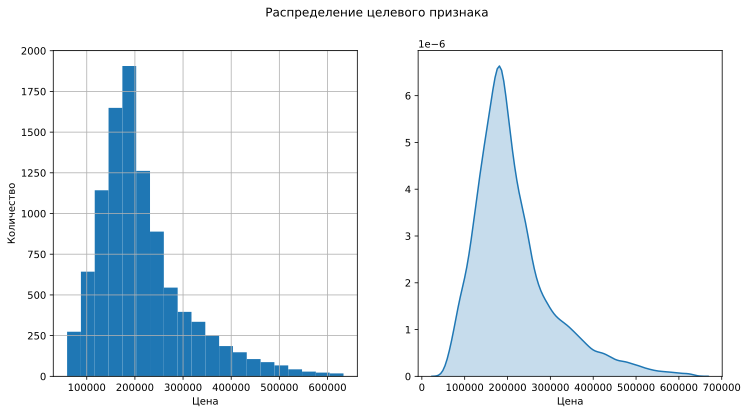

In [4114]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
train_df['Price'].hist(density=False, bins=20)
plt.ylabel('Количество')
plt.xlabel('Цена')

plt.subplot(1, 2, 2)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('Цена')

plt.suptitle('Распределение целевого признака')
plt.show()

Посчитаем медиану и среднее и нанесем на график.

Среднее - 214139.21875
Медиана - 192269.65625


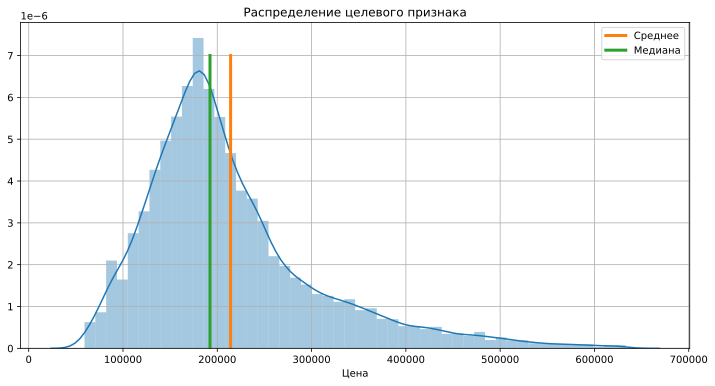

In [4115]:
target_mean = train_df['Price'].mean()
target_median = train_df['Price'].median()
print(f'Среднее - {target_mean}\nМедиана - {target_median}')

plt.figure(figsize = (12, 6))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000007, 10)
plt.plot([target_mean] * 10, y, label='Среднее', linewidth=3)
plt.plot([target_median] * 10, y, label='Медиана', linewidth=3)

plt.title('Распределение целевого признака')
plt.xlabel('Цена')
plt.legend()
plt.grid()
plt.show()

Распределение логнормальное.

Можно приступить к анализу признаков.

In [4116]:
train_df.isna().sum()  #еще раз можем посмотреть, где пропуски

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Healthcare_2        0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

По количественным признакам построим гистограммы

In [4117]:
df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16', 'int64', 'int32', 'int16', 'int8'])
df_num_features.drop('Price', axis=1, inplace=True)
df_num_features.head()

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
0          35    2.0  47.981560   29.442751            6.0      7         9.0   
1          41    3.0  65.683640   40.049541            8.0      7         9.0   
2          53    2.0  44.947952   29.197611            0.0      8        12.0   
3          58    2.0  53.352982   52.731510            9.0      8        17.0   
4          99    1.0  39.649193   23.776169            7.0     11        12.0   

   HouseYear  Ecology_1  Social_1  Social_2  Social_3  Healthcare_1  \
0       1969   0.089040        33      7976         5           NaN   
1       1978   0.000070        46     10309         1         240.0   
2       1968   0.049637        34      7759         0         229.0   
3       1977   0.437885        23      5735         3        1084.0   
4       1976   0.012339        35      5776         1        2078.0   

   Healthcare_2  Shops_1  
0             0       11  
1             1       16  
2             1        3  
3             0        5  
4             2        4

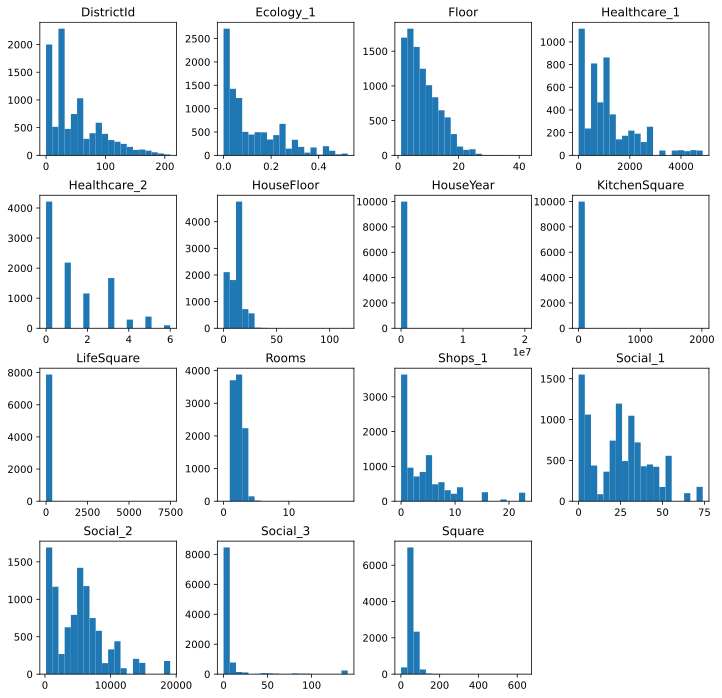

In [4118]:
df_num_features.hist(figsize=(12,12), bins=20, grid=False);

In [4119]:
df_num_features.describe().T #основные статистики по количественным признакам

count         mean            std          min          25%  \
DistrictId     10000.0    50.400800      43.587592     0.000000    20.000000   
Rooms          10000.0     1.890500       0.839523     0.000000     1.000000   
Square         10000.0    56.315712      21.058718     1.136859    41.774879   
LifeSquare      7887.0    37.199596      86.241112     0.370619    22.769833   
KitchenSquare  10000.0     6.273300      28.561113     0.000000     1.000000   
Floor          10000.0     8.526700       5.241148     1.000000     4.000000   
HouseFloor     10000.0    12.609400       6.776192     0.000000     9.000000   
HouseYear      10000.0  3990.166300  200500.261427  1910.000000  1974.000000   
Ecology_1      10000.0     0.118858       0.119026     0.000000     0.017647   
Social_1       10000.0    24.687000      17.532614     0.000000     6.000000   
Social_2       10000.0  5352.157400    4006.799803   168.000000  1564.000000   
Social_3       10000.0     8.039200      23.831875     0.000000     0.000000   
Healthcare_1    5202.0  1142.904419    1021.518982     0.000000   350.000000   
Healthcare_2   10000.0     1.319500       1.493601     0.000000     0.000000   
Shops_1        10000.0     4.231300       4.806341     0.000000     1.000000   

                       50%          75%           max  
DistrictId       36.000000    75.000000  2.090000e+02  
Rooms             2.000000     2.000000  1.900000e+01  
Square           52.513309    65.900627  6.410652e+02  
LifeSquare       32.781261    45.128803  7.480592e+03  
KitchenSquare     6.000000     9.000000  2.014000e+03  
Floor             7.000000    12.000000  4.200000e+01  
HouseFloor       13.000000    17.000000  1.170000e+02  
HouseYear      1977.000000  2001.000000  2.005201e+07  
Ecology_1         0.075424     0.195781  5.218670e-01  
Social_1         25.000000    36.000000  7.400000e+01  
Social_2       5285.000000  7227.000000  1.908300e+04  
Social_3          2.000000     5.000000  1.410000e+02  
Healthcare_1    900.000000  1548.000000  4.849000e+03  
Healthcare_2      1.000000     2.000000  6.000000e+00  
Shops_1           3.000000     6.000000  2.300000e+01

Обработаем каждый признак отдельно

## Rooms

In [4120]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Значения 0, 10, 19 являются выбросами. Значит значения меньше 1 и больше 6 заменяем на медиану.

In [4121]:
train_df.loc[(train_df['Rooms'] > 5) | (train_df['Rooms'] < 1), 'Rooms'] = train_df['Rooms'].median() 
train_df['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

## Square

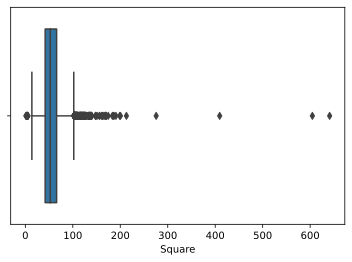

In [4122]:
sns.boxplot(train_df['Square'], whis=1.5);


Посмотрим на значения более квантиля 99.5% и меньше квантиля 0.5% и их сумму

In [4123]:
train_df[train_df['Square'] > (np.quantile(train_df['Square'], q=0.995))].head()


Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
496    8158          74    3.0  134.231522         NaN            1.0      4   
652    3718          56    3.0  190.857681  107.376167           19.0      7   
1355  10263          74    3.0  138.700089         NaN            1.0      2   
1397  12638          27    2.0  138.427689  136.215500            0.0      4   
1641  11055         151    1.0  174.649521  174.837082           15.0     10   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
496          3.0       1977   0.309479         B         B        35   
652          3.0       2007   0.000000         B         B        23   
1355         3.0       1977   0.309479         B         B        35   
1397         3.0       2016   0.075424         B         B        11   
1641        12.0       1958   0.236108         B         B        16   

      Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  \
496       7715         4         990.0             0        6       B   
652       5067         4           NaN             2        6       B   
1355      7715         4         990.0             0        6       B   
1397      3097         0           NaN             0        0       B   
1641      3893        27           NaN             3       10       B   

              Price  
496   181837.046875  
652   338644.062500  
1355  195831.984375  
1397  268394.750000  
1641  232766.187500

In [4124]:
(train_df['Square'] > (np.quantile(train_df['Square'], q=0.995))).sum()

50

In [4125]:
train_df[train_df['Square'] < (np.quantile(train_df['Square'], q=0.005))].head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
212    1748          88    2.0   5.497061   67.628716            1.0     24   
431    6629           3    1.0  25.761152   15.614058            5.0      4   
501   15923          27    1.0  26.553188         NaN            0.0     25   
900    8940          34    1.0  26.811586         NaN            0.0     18   
1316  11526          27    1.0   4.633498    1.969969            1.0     18   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
212         22.0       1977   0.127376         B         B        43   
431          9.0       1976   0.050900         B         B        43   
501          0.0       1977   0.072158         B         B         2   
900          0.0       1977   0.069753         B         B        53   
1316         1.0       1977   0.011654         B         B         4   

      Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  \
212       8429         3           NaN             3        9       B   
431      10621         1          30.0             2        3       B   
501        629         1           NaN             0        0       A   
900      13670         4           NaN             1       11       B   
1316       915         0           NaN             0        0       B   

              Price  
212   412511.093750  
431   102046.203125  
501   114256.234375  
900   175399.640625  
1316  107604.265625

In [4126]:
(train_df['Square'] < (np.quantile(train_df['Square'], q=0.005))).sum()

50

Все, что за пределами этих значений, примем за выбросы и заменим медианой.

In [4127]:
square_max_value = np.quantile(train_df['Square'], q=0.995)
square_max_value


132.82090370178219

In [4128]:
square_min_value = np.quantile(train_df['Square'], q=0.005)
square_min_value

27.245410060882566

In [4129]:
train_df.loc[(train_df['Square'] > square_max_value) | (train_df['Square'] < square_min_value), 'Square'] = train_df['Square'].median()
train_df['Square'].describe()

count    10000.000000
mean        55.841831
std         17.523338
min         27.245731
25%         41.891181
50%         52.513309
75%         65.687443
max        132.820648
Name: Square, dtype: float64

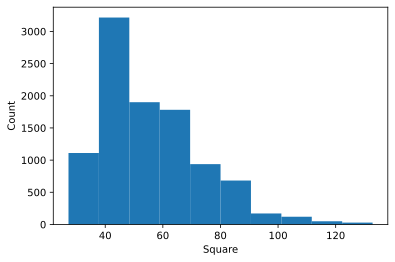

In [4130]:
train_df['Square'].hist(grid=False);
plt.xlabel('Square');
plt.ylabel('Count');

## Kitchen Square

In [4131]:
k_square_max_value = np.quantile(train_df['KitchenSquare'], q=0.985)
k_square_max_value

14.0

In [4132]:
k_square_min_value = np.quantile(train_df['KitchenSquare'], q=0.015)
k_square_min_value

0.0

Выбросами будет считать кухни площадью менее 2 и более 13 кв. м.

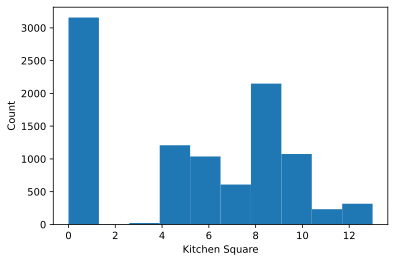

In [4133]:
train_df['KitchenSquare'][train_df['KitchenSquare'] < 14].hist(grid=False)
plt.xlabel('Kitchen Square');
plt.ylabel('Count');

In [4134]:
train_df.loc[(train_df['KitchenSquare'] > k_square_max_value) | (train_df['KitchenSquare'] < 2), 'KitchenSquare'] = train_df['KitchenSquare'].median() #заменим на медиану
train_df['KitchenSquare'].describe()

count    10000.000000
mean         7.225700
std          1.962722
min          2.000000
25%          6.000000
50%          6.000000
75%          9.000000
max         14.000000
Name: KitchenSquare, dtype: float64

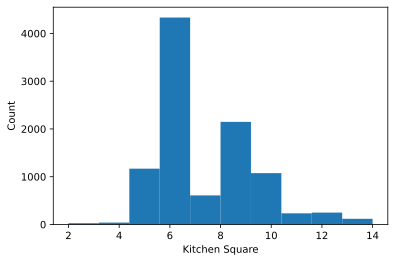

In [4135]:
train_df['KitchenSquare'].hist(grid=False)
plt.xlabel('Kitchen Square');
plt.ylabel('Count');

## Life Square
Жилая площадь не может быть больше чем общая, также не забываем обработать пропуски. Есть два варианта заполнения пропусков - заменить медианой, либо приблизительно ее вычислить, вычтя из общей площадь кухни и санузлов (возьмем за 4 кв.м). Я выбрала второй вариант.

In [4136]:
train_df['LifeSquare'].isnull().sum()

2113

Парадоксы

In [4137]:
(train_df['LifeSquare'] > train_df['Square']).sum()

495

Сначала обработаем парадоксы с ориентировкой на общую площадь.

In [4138]:
train_df.loc[(train_df['LifeSquare'] > train_df['Square']), 'LifeSquare'] = (train_df.loc[(train_df['LifeSquare'] > train_df['Square']), 'Square']) - (train_df.loc[(train_df['LifeSquare'] > train_df['Square']), 'KitchenSquare']) - 4

In [4139]:
(train_df['LifeSquare']>train_df['Square']).sum()

0

Теперь обработаем пропуски

In [4140]:
train_df.loc[(train_df['LifeSquare'].isnull()), 'LifeSquare'] = (train_df.loc[(train_df['LifeSquare'].isnull()), 'Square']) - (train_df.loc[(train_df['LifeSquare'].isnull()), 'KitchenSquare']) - 4

In [4141]:
train_df['LifeSquare'].isnull().sum()

0

Выбросы заменим на медиану

In [4142]:
l_square_max_value = np.quantile(train_df['LifeSquare'], q=0.975)
l_square_max_value

78.74821586608884

In [4143]:
l_square_min_value = np.quantile(train_df['LifeSquare'], q=0.025)
l_square_min_value

15.139062023162843

In [4144]:
train_df.loc[(train_df['LifeSquare'] > l_square_max_value) | (train_df['LifeSquare'] < l_square_min_value), 'LifeSquare'] = train_df['LifeSquare'].median()

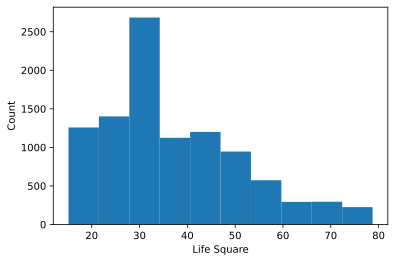

In [4145]:
train_df['LifeSquare'].hist(grid=False);
plt.xlabel('Life Square');
plt.ylabel('Count');

In [4146]:
train_df['LifeSquare'].describe()

count    10000.000000
mean        37.269108
std         14.061276
min         15.139651
25%         26.821341
50%         33.956448
75%         46.155115
max         78.746445
Name: LifeSquare, dtype: float64

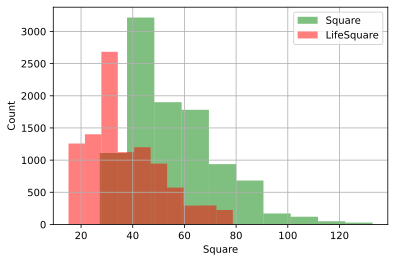

In [4147]:
train_df['Square'].hist(alpha=0.5, label='Square', color='green');
train_df['LifeSquare'].hist(alpha=0.5, label='LifeSquare', color='red');
plt.xlabel('Square');
plt.ylabel('Count');
plt.legend();

## Floor, HouseFloor

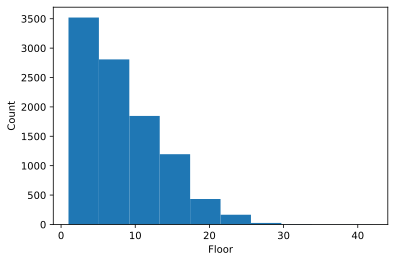

In [4148]:
train_df['Floor'].hist(grid=False);
plt.xlabel('Floor');
plt.ylabel('Count');

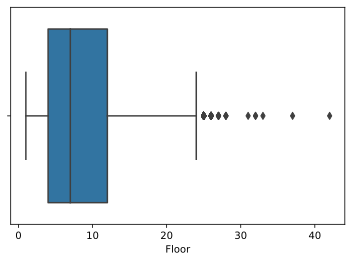

In [4149]:
sns.boxplot(train_df['Floor'], whis=1.5);

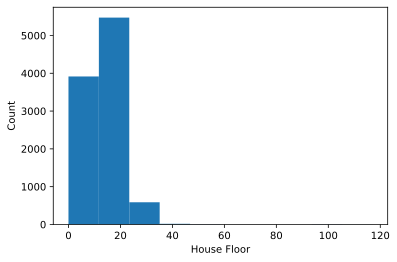

In [4150]:
train_df['HouseFloor'].hist(grid=False);
plt.xlabel('House Floor');
plt.ylabel('Count');

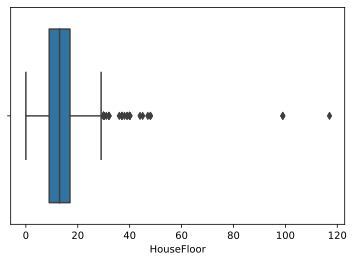

In [4151]:
sns.boxplot(train_df['HouseFloor'], whis=1.5);

In [4152]:
train_df[['Floor', 'HouseFloor']].describe().T

count     mean       std  min  25%   50%   75%    max
Floor       10000.0   8.5267  5.241148  1.0  4.0   7.0  12.0   42.0
HouseFloor  10000.0  12.6094  6.776192  0.0  9.0  13.0  17.0  117.0

In [4153]:
# количество объектов, где этаж указан больше, чем есть этажей в доме (выбросы) 
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [4154]:
train_df['Floor'].sort_values().unique() # смотрим уникальные значения, выбросы = этаж больше этажности

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [4155]:
train_df['HouseFloor'].sort_values().unique() # смотрим уникальные значения (> 59 выбросы, самый высокий ЖК из вики)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [4156]:
train_df.loc[(train_df['HouseFloor'] > 59), 'HouseFloor'] = train_df['HouseFloor'].median()

In [4157]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']), 'Floor'] = train_df['Floor'].median()

In [4158]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']), 'HouseFloor'] = train_df['HouseFloor'].median()

In [4159]:
(train_df['Floor']>train_df['HouseFloor']).sum()

0

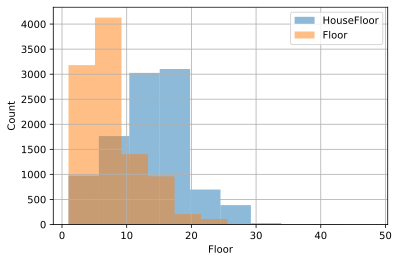

In [4160]:
train_df['HouseFloor'].hist(alpha=0.5, label='HouseFloor')
train_df['Floor'].hist(alpha=0.5, label='Floor')
plt.xlabel('Floor')
plt.ylabel('Count')
plt.legend();

## HouseYear

In [4161]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
1499        2020
5701        2020
7076        2020
          ...   
7611        1916
910         1914
5111        1912
2656        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int32

In [4162]:
train_df['HouseYear'].mode() 

0    1977
dtype: int32

Выбросы (год постройки позже 2022) заменяем на моду (наиболее часто встречаемое наблюдение).

In [4163]:
train_df.loc[train_df['HouseYear'] > 2022, 'HouseYear'] = train_df['HouseYear'].mode()[0]

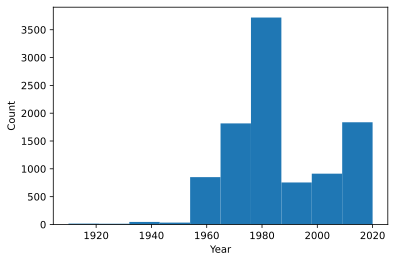

In [4164]:
train_df['HouseYear'].hist(grid=False);
plt.xlabel('Year');
plt.ylabel('Count');

Посмотрим еще раз на общую сводку

In [4165]:
train_df.describe().T

count           mean           std           min  \
DistrictId     10000.0      50.400800     43.587592      0.000000   
Rooms          10000.0       1.888400      0.811071      1.000000   
Square         10000.0      55.841831     17.523338     27.245731   
LifeSquare     10000.0      37.269108     14.061276     15.139651   
KitchenSquare  10000.0       7.225700      1.962722      2.000000   
Floor          10000.0       7.849100      4.528596      1.000000   
HouseFloor     10000.0      13.850700      5.320466      1.000000   
HouseYear      10000.0    1984.863800     18.409979   1910.000000   
Ecology_1      10000.0       0.118858      0.119026      0.000000   
Social_1       10000.0      24.687000     17.532614      0.000000   
Social_2       10000.0    5352.157400   4006.799803    168.000000   
Social_3       10000.0       8.039200     23.831875      0.000000   
Healthcare_1    5202.0    1142.904419   1021.518982      0.000000   
Healthcare_2   10000.0       1.319500      1.493601      0.000000   
Shops_1        10000.0       4.231300      4.806341      0.000000   
Price          10000.0  214139.218750  92872.304688  59174.777344   

                         25%            50%            75%            max  
DistrictId         20.000000      36.000000      75.000000     209.000000  
Rooms               1.000000       2.000000       2.000000       5.000000  
Square             41.891181      52.513309      65.687443     132.820648  
LifeSquare         26.821341      33.956448      46.155115      78.746445  
KitchenSquare       6.000000       6.000000       9.000000      14.000000  
Floor               5.000000       7.000000      10.000000      42.000000  
HouseFloor          9.000000      13.000000      17.000000      48.000000  
HouseYear        1974.000000    1977.000000    2001.000000    2020.000000  
Ecology_1           0.017647       0.075424       0.195781       0.521867  
Social_1            6.000000      25.000000      36.000000      74.000000  
Social_2         1564.000000    5285.000000    7227.000000   19083.000000  
Social_3            0.000000       2.000000       5.000000     141.000000  
Healthcare_1      350.000000     900.000000    1548.000000    4849.000000  
Healthcare_2        0.000000       1.000000       2.000000       6.000000  
Shops_1             1.000000       3.000000       6.000000      23.000000  
Price          153872.628906  192269.648438  249135.460938  633233.437500

Признак Healthcare_1 имеет много пропусков, его решила убрать вовсе.

In [4166]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

## Матрица корреляций

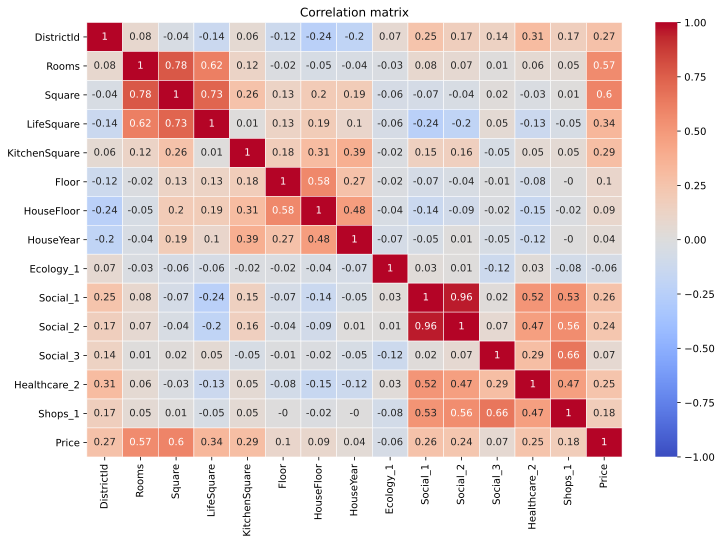

In [4167]:
plt.figure(figsize = (12,8))
sns.heatmap(np.round(train_df.corr(), 2), 
            annot=True, linewidths=.5, cmap='coolwarm', vmin=-1, vmax=1, center= 0)
plt.title('Correlation matrix');

Сильная корреляционная связь между Social_1 и Soсial_2 - удалим последний.

In [4168]:
train_df.drop('Social_2', axis=1, inplace=True)

In [4169]:
train_df.describe().T

count           mean           std           min  \
DistrictId     10000.0      50.400800     43.587592      0.000000   
Rooms          10000.0       1.888400      0.811071      1.000000   
Square         10000.0      55.841831     17.523338     27.245731   
LifeSquare     10000.0      37.269108     14.061276     15.139651   
KitchenSquare  10000.0       7.225700      1.962722      2.000000   
Floor          10000.0       7.849100      4.528596      1.000000   
HouseFloor     10000.0      13.850700      5.320466      1.000000   
HouseYear      10000.0    1984.863800     18.409979   1910.000000   
Ecology_1      10000.0       0.118858      0.119026      0.000000   
Social_1       10000.0      24.687000     17.532614      0.000000   
Social_3       10000.0       8.039200     23.831875      0.000000   
Healthcare_2   10000.0       1.319500      1.493601      0.000000   
Shops_1        10000.0       4.231300      4.806341      0.000000   
Price          10000.0  214139.218750  92872.304688  59174.777344   

                         25%            50%            75%            max  
DistrictId         20.000000      36.000000      75.000000     209.000000  
Rooms               1.000000       2.000000       2.000000       5.000000  
Square             41.891181      52.513309      65.687443     132.820648  
LifeSquare         26.821341      33.956448      46.155115      78.746445  
KitchenSquare       6.000000       6.000000       9.000000      14.000000  
Floor               5.000000       7.000000      10.000000      42.000000  
HouseFloor          9.000000      13.000000      17.000000      48.000000  
HouseYear        1974.000000    1977.000000    2001.000000    2020.000000  
Ecology_1           0.017647       0.075424       0.195781       0.521867  
Social_1            6.000000      25.000000      36.000000      74.000000  
Social_3            0.000000       2.000000       5.000000     141.000000  
Healthcare_2        0.000000       1.000000       2.000000       6.000000  
Shops_1             1.000000       3.000000       6.000000      23.000000  
Price          153872.628906  192269.648438  249135.460938  633233.437500

### Ecology_1

In [4170]:
train_df['Ecology_1'].describe()

count    10000.000000
mean         0.118858
std          0.119026
min          0.000000
25%          0.017647
50%          0.075424
75%          0.195781
max          0.521867
Name: Ecology_1, dtype: float64

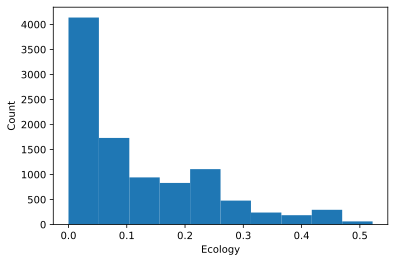

In [4171]:
train_df['Ecology_1'].hist(grid=False);
plt.xlabel('Ecology');
plt.ylabel('Count');

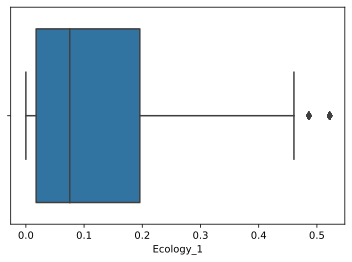

In [4172]:
sns.boxplot(train_df['Ecology_1'], whis=1.5);

In [4173]:
(train_df['Ecology_1'] > (np.quantile(train_df['Ecology_1'], q=0.975))).sum()

159

У нас присутствует 159 выбросов за пределами 97.5% квантиля, заменим их на медиану

In [4174]:
train_df.loc[(train_df['Ecology_1'] >(np.quantile(train_df['Ecology_1'], q=0.975))), 'Ecology_1'] = train_df['Ecology_1'].median()

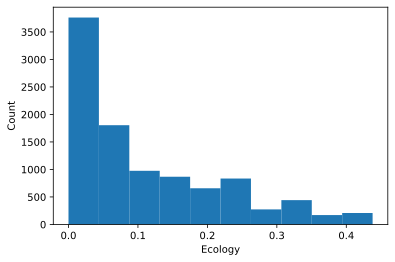

In [4175]:
train_df['Ecology_1'].hist(grid=False);
plt.xlabel('Ecology');
plt.ylabel('Count');

In [4176]:
train_df['Ecology_1'].describe()

count    10000.000000
mean         0.112455
std          0.109964
min          0.000000
25%          0.017647
50%          0.075424
75%          0.188784
max          0.437885
Name: Ecology_1, dtype: float64

### Shops_1

In [4177]:
train_df['Ecology_1'].describe()

count    10000.000000
mean         0.112455
std          0.109964
min          0.000000
25%          0.017647
50%          0.075424
75%          0.188784
max          0.437885
Name: Ecology_1, dtype: float64

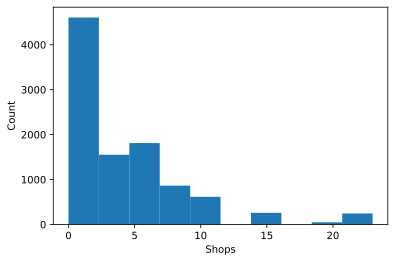

In [4178]:
train_df['Shops_1'].hist(grid=False);
plt.xlabel('Shops');
plt.ylabel('Count');

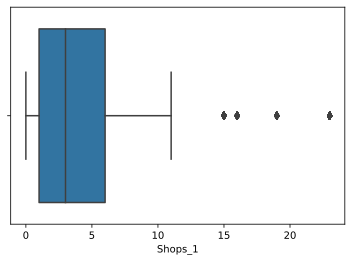

In [4179]:
sns.boxplot(train_df['Shops_1'], whis=1.5);

In [4180]:
train_df['Shops_1'].mode()

0    0
dtype: int8

In [4181]:
train_df['Shops_1'].median()

3.0

In [4182]:
train_df.loc[(train_df['Shops_1'] > 10), 'Shops_1'] = train_df['Shops_1'].median()
#выбросы больше значения 10 заменили на медиану

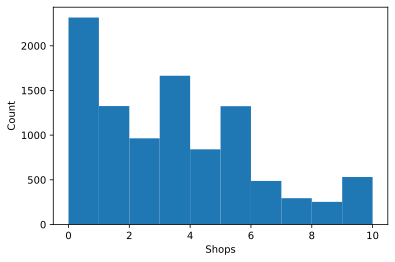

In [4183]:
train_df['Shops_1'].hist(grid=False);
plt.xlabel('Shops');
plt.ylabel('Count');

### Social_1

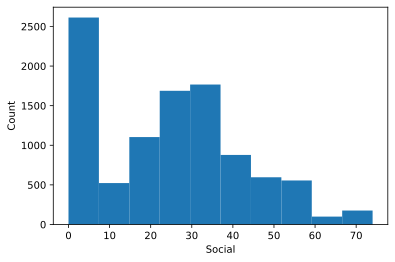

In [4184]:
train_df['Social_1'].hist(grid=False);
plt.xlabel('Social');
plt.ylabel('Count');

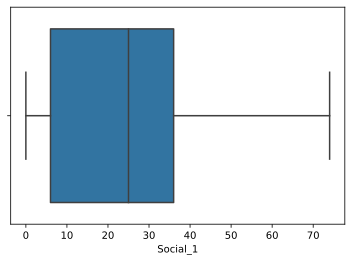

In [4185]:
sns.boxplot(train_df['Social_1'], whis=1.5);

In [4186]:
train_df['Social_1'].describe()

count    10000.000000
mean        24.687000
std         17.532614
min          0.000000
25%          6.000000
50%         25.000000
75%         36.000000
max         74.000000
Name: Social_1, dtype: float64

Выбросов нет.

### Social_3

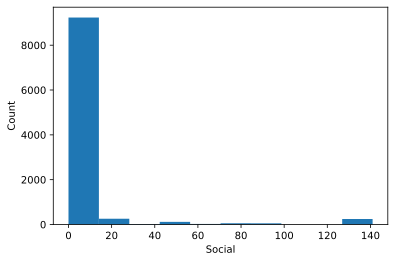

In [4187]:
train_df['Social_3'].hist(grid=False);
plt.xlabel('Social');
plt.ylabel('Count');

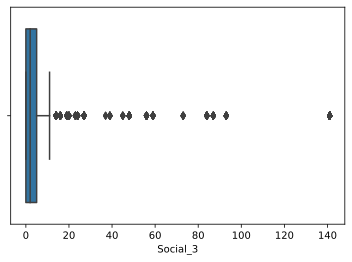

In [4188]:
sns.boxplot(train_df['Social_3'], whis=1.5);

In [4189]:
train_df['Social_3'].describe()

count    10000.000000
mean         8.039200
std         23.831875
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        141.000000
Name: Social_3, dtype: float64

In [4190]:
(train_df['Social_3'] > np.quantile(train_df['Social_3'],q=0.95)).sum()

491

In [4191]:
train_df.loc[(train_df['Social_3'] > np.quantile(train_df['Social_3'],q=0.95)), 'Social_3']\
= train_df['Social_3'].median()

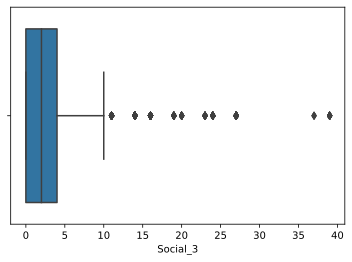

In [4192]:
sns.boxplot(train_df['Social_3'], whis=1.5);

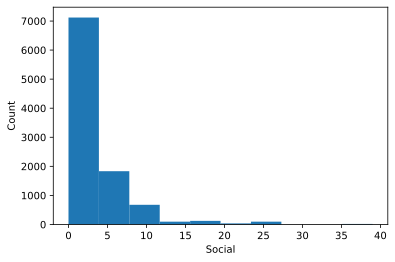

In [4193]:
train_df['Social_3'].hist(grid=False);
plt.xlabel('Social');
plt.ylabel('Count');

## Категориальные признаки. Создание новых признаков

Далее остались категориальные признаки DistrictId, Ecology_2, Ecology_3, Social_1, Social_3, Healthcare_2, Shops_2.

### DistrictId

In [4194]:
train_df['DistrictId'].value_counts()


27     851
1      652
23     565
6      511
9      294
      ... 
199      1
205      1
174      1
209      1
207      1
Name: DistrictId, Length: 205, dtype: int64

Будем разбивать районы на большой и маленький с помощью признака IdDistrictLarge (0 и 1), для этого сначала нужно посчитать количество объектов с таким ID.
Создадим новый признак DistrictSize 

In [4195]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

DistrictId  DistrictSize
0          27           851
1           1           652
2          23           565
3           6           511
4           9           294

In [4196]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981560   29.442751            6.0    7.0   
1  15053          41    3.0  65.683640   40.049541            8.0    7.0   
2   4765          53    2.0  44.947952   29.197611            6.0    8.0   
3   5809          58    2.0  53.352982   52.731510            9.0    8.0   
4  10783          99    1.0  39.649193   23.776169            7.0   11.0   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_3  \
0         9.0       1969   0.089040         B         B        33       5.0   
1         9.0       1978   0.000070         B         B        46       1.0   
2        12.0       1968   0.049637         B         B        34       0.0   
3        17.0       1977   0.437885         B         B        23       3.0   
4        12.0       1976   0.012339         B         B        35       1.0   

   Healthcare_2  Shops_1 Shops_2          Price  DistrictSize  
0             0      3.0       B  184966.937500            22  
1             1      3.0       B  300009.437500            87  
2             1      3.0       B  220925.906250           174  
3             0      5.0       B  175616.234375           179  
4             2      4.0       B  150226.531250            97

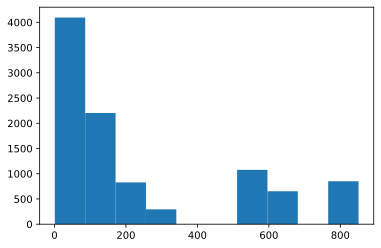

In [4197]:
train_df['DistrictSize'].hist(grid=False);


Установим границу в 400 домов


In [4198]:
train_df.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981560   29.442751            6.0    7.0   
1  15053          41    3.0  65.683640   40.049541            8.0    7.0   
2   4765          53    2.0  44.947952   29.197611            6.0    8.0   
3   5809          58    2.0  53.352982   52.731510            9.0    8.0   
4  10783          99    1.0  39.649193   23.776169            7.0   11.0   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_3  \
0         9.0       1969   0.089040         B         B        33       5.0   
1         9.0       1978   0.000070         B         B        46       1.0   
2        12.0       1968   0.049637         B         B        34       0.0   
3        17.0       1977   0.437885         B         B        23       3.0   
4        12.0       1976   0.012339         B         B        35       1.0   

   Healthcare_2  Shops_1 Shops_2          Price  DistrictSize  
0             0      3.0       B  184966.937500            22  
1             1      3.0       B  300009.437500            87  
2             1      3.0       B  220925.906250           174  
3             0      5.0       B  175616.234375           179  
4             2      4.0       B  150226.531250            97

In [4199]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 400).astype(int)

In [4200]:
train_df.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
9995    77          32    2.0  50.401787   30.476204            5.0    7.0   
9996  6159          18    1.0  41.521545   20.539215            9.0   13.0   
9997  5123          27    1.0  47.939007   37.939007            6.0   12.0   
9998  5400          75    2.0  43.602562   33.840149            8.0    1.0   
9999  6306         128    1.0  38.666645   21.157875            8.0    7.0   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
9995        13.0       1968   0.135650         B         B        46   
9996        13.0       2000   0.000000         B         B        30   
9997        16.0       2015   0.072158         B         B         2   
9998         5.0       1961   0.307467         B         A        30   
9999        17.0       1990   0.000000         B         B        27   

      Social_3  Healthcare_2  Shops_1 Shops_2          Price  DistrictSize  \
9995       6.0             3      3.0       B  196684.312500            34   
9996       0.0             0      5.0       A  189050.296875            51   
9997       1.0             0      0.0       A  159143.812500           851   
9998       9.0             2      5.0       B  181595.343750            66   
9999       0.0             2      8.0       B  218714.078125            64   

      IsDistrictLarge  
9995                0  
9996                0  
9997                1  
9998                0  
9999                0

In [4201]:
train_df.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
9995    77          32    2.0  50.401787   30.476204            5.0    7.0   
9996  6159          18    1.0  41.521545   20.539215            9.0   13.0   
9997  5123          27    1.0  47.939007   37.939007            6.0   12.0   
9998  5400          75    2.0  43.602562   33.840149            8.0    1.0   
9999  6306         128    1.0  38.666645   21.157875            8.0    7.0   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
9995        13.0       1968   0.135650         B         B        46   
9996        13.0       2000   0.000000         B         B        30   
9997        16.0       2015   0.072158         B         B         2   
9998         5.0       1961   0.307467         B         A        30   
9999        17.0       1990   0.000000         B         B        27   

      Social_3  Healthcare_2  Shops_1 Shops_2          Price  DistrictSize  \
9995       6.0             3      3.0       B  196684.312500            34   
9996       0.0             0      5.0       A  189050.296875            51   
9997       1.0             0      0.0       A  159143.812500           851   
9998       9.0             2      5.0       B  181595.343750            66   
9999       0.0             2      8.0       B  218714.078125            64   

      IsDistrictLarge  
9995                0  
9996                0  
9997                1  
9998                0  
9999                0

### Healthcare_2

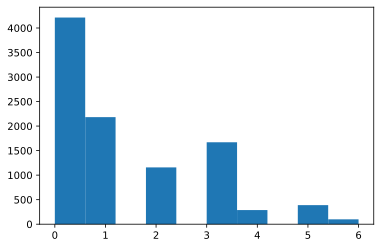

In [4053]:
train_df['Healthcare_2'].hist(grid=False);

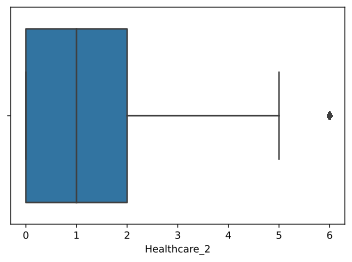

In [4054]:
sns.boxplot(train_df['Healthcare_2'], whis=1.5);

In [4055]:
(train_df['Healthcare_2'] > 5).sum()

99

In [4056]:
train_df['Healthcare_2'].mode()

0    0
dtype: int8

In [4057]:
#99 выбросов со значением больше 5 заменим модой
train_df.loc[(train_df['Healthcare_2'] > 5), 'Healthcare_2'] = train_df['Healthcare_2'].mode()[0]

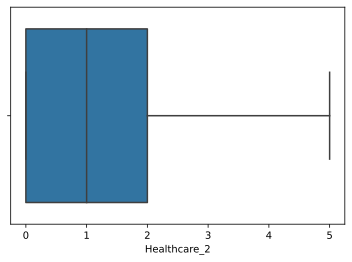

In [4058]:
sns.boxplot(train_df['Healthcare_2'], whis=1.5);

### Ecology_2

In [4059]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [4060]:
train_df['Ecology_3'].value_counts()


B    9725
A     275
Name: Ecology_3, dtype: int64

In [4061]:
train_df['Shops_2'].value_counts()


B    9175
A     825
Name: Shops_2, dtype: int64

Заменим А и В на 0 и 1

In [4062]:
bin_to_num = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(bin_to_num)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(bin_to_num)
train_df['Shops_2'] = train_df['Shops_2'].replace(bin_to_num)

In [4063]:
train_df[['Ecology_2', 'Ecology_3', 'Shops_2']].head()


Ecology_2  Ecology_3  Shops_2
0          1          1        1
1          1          1        1
2          1          1        1
3          1          1        1
4          1          1        1

In [4064]:
df_obj_features = train_df.select_dtypes(include='object')
df_obj_features.head()

Id
0  14038
1  15053
2   4765
3   5809
4  10783

In [4065]:
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_3         0
Healthcare_2     0
Shops_1          0
Shops_2          0
Price            0
DistrictSize     0
DistrSize1       0
DistrSize2       0
DistrSize3       0
SqMPrice         0
AvrgSqMPrice     0
dtype: int64

In [4068]:
#посмотрим, сколько домов находится в районах в тестовом датасете, id которых нет в трейне. Таких домов 8.

value_to_drop = train_df['DistrictId'].values # значения, которые хотим исключить из test
flt = ~test_df['DistrictId'].isin(value_to_drop) # оставляем только те значения, которые уникальны для test
test_df.loc[flt, :] # результат


Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
51    15748         212    2.0  75.655182   36.877626           15.0      2   
1043  14939         210    2.0  54.953826   31.223917            6.0      3   
1475  16217         206    4.0  76.428426   50.344903           11.0      7   
2323   9155         204    3.0  88.559337   62.854221            8.0      8   
2370   8845         203    2.0  50.417709   27.587971            7.0      5   
2666  15655         211    2.0  46.501558   32.276987            5.0      5   
3668  13382         206    2.0  46.047289   27.384090            6.0      5   
4046  14024         198    2.0  47.477281   31.069466            5.0      2   

      HouseFloor  HouseYear     Ecology_1 Ecology_2 Ecology_3  Social_1  \
51           7.0       1929  0.000000e+00         B         B         8   
1043        10.0       1956  8.194346e-02         B         B        20   
1475         6.0       1912  4.203159e-02         B         B        37   
2323         7.0       1918  3.731645e-02         B         B        32   
2370         4.0       1977  1.501689e-02         B         B        17   
2666         5.0       1965  1.800000e-09         B         B        16   
3668         7.0       1930  7.815280e-05         B         B        22   
4046         5.0       1970  6.076152e-03         B         B        30   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
51        1423        37         562.0            1        8       B  
1043      2738        20           NaN            1        4       B  
1475      6856        84        1940.0            2        5       B  
2323      6748        93         562.0            4       10       B  
2370      3079        59        2890.0            0        8       B  
2666      3681        73        1815.0            2        5       B  
3668      6398       141        1046.0            3       23       B  
4046      5285         0         645.0            6        6       B

## Оформим все в виде классов

In [4202]:
class DataPipeline:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.square_quantile_005 = None
        self.square_quantile_995 = None
        self.distr_size_cat = None
        self.DistrictId_counts = None
        self.bin_to_num = None
        self.district_size = None
        self.distr_cat = None
                
    def fit(self, df, df_price=None):
        """Сохранение статистик"""       
        # Расчет медиан, моды, квантилей
        self.medians = df.median()
        self.house_year_mode = df['HouseYear'].mode()[0]
        self.square_quantile_005 = df['Square'].quantile(0.005)
        self.square_quantile_995 = df['Square'].quantile(0.995)
        self.kitchen_square_quantile_985 = df['KitchenSquare'].quantile(0.985)
        self.life_square_quantile_975 = df['LifeSquare'].quantile(0.975)
        self.life_square_quantile_025 = df['LifeSquare'].quantile(0.025)
        self.ecology_1_quantile_975 = df['Ecology_1'].quantile(0.975)
        self.social_3_quantile_975 = df['Social_3'].quantile(0.975)


        """Генерация новых признаков"""
        # Binary features
        self.bin_to_num = {'A': 0, 'B': 1}
        
        # DistrictSize
        self.district_size = df['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        df = df.merge(self.district_size, on='DistrictId', how='left')
        
        
        return df
        
            
    def transform(self, df):
        """Трансформация данных"""
        
        
        # Rooms
        df.loc[(df['Rooms'] > 5) | (df['Rooms'] < 1), 'Rooms'] = self.medians['Rooms']
        
        # Square
        condition = ((df['Square'] > self.square_quantile_995) | (df['Square'] < self.square_quantile_005))
        df.loc[condition, 'Square'] = self.medians['Square']
                         
        # KitchenSquare
        condition = ((df['KitchenSquare'] < 2) | (df['KitchenSquare'] > self.kitchen_square_quantile_985))
        df.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        #LifeSquare
        square_condition = (df['LifeSquare'] > df['Square'])
        df.loc[square_condition, 'LifeSquare'] = (df.loc[square_condition, 'Square'])\
        - (df.loc[square_condition, 'KitchenSquare']) - 4             
                     
        df['LifeSquare'].fillna(self.medians['LifeSquare'], inplace=True) #обработка пропусков
        
        condition = (df['LifeSquare'] > self.life_square_quantile_975) | (train_df['LifeSquare'] < self.life_square_quantile_025)
        df.loc[condition, 'LifeSquare'] = self.medians['LifeSquare']
                
        
        # HouseFloor, Floor
        condition1 = (df['Floor'] > df['HouseFloor'])
        condition2 = (df['HouseFloor'] > 59)     
        df.loc[condition2, 'HouseFloor'] = self.medians['HouseFloor']             
        df.loc[condition1, 'Floor'] = self.medians['Floor']
        df.loc[condition2, 'HouseFloor'] = self.medians['HouseFloor']             
        
        # HouseYear
        
        df.loc[df['HouseYear'] > 2022, 'HouseYear'] = self.house_year_mode
        
        #Ecology_1             
        df.loc[(df['Ecology_1'] > self.ecology_1_quantile_975), 'Ecology_1'] = self.medians['Ecology_1']             
        
        #Shops_1
        df.loc[(df['Shops_1'] > 12), 'Shops_1'] = self.medians['Shops_1']
                     
        # Healthcare_1
        if 'Healthcare_1' in df.columns:
            df.drop('Healthcare_1', axis=1, inplace=True)
            
        # Healthcare_2
        if 'Helthcare_2' in df.columns:
            df.rename(columns={'Helthcare_2':'Healthcare_2'}, inplace=True) 
            
        # Social_2
        if 'Social_2' in df.columns:
            df.drop('Social_2', axis=1, inplace=True)        
        
        #Social_3
        df.loc[(df['Social_3'] > self.social_3_quantile_975), 'Social_3'] = self.medians['Social_3']
        
        # Binary features
        df['Ecology_2'] = df['Ecology_2'].replace(self.bin_to_num)  # self.bin_to_num = {'A': 0, 'B': 1}
        df['Ecology_3'] = df['Ecology_3'].replace(self.bin_to_num)
        df['Shops_2'] = df['Shops_2'].replace(self.bin_to_num)
        
        # DistrictSize: соединяем новый признак DistrictSize с датасетом 
        df = df.merge(self.district_size, on='DistrictId', how='left')
        
        # IsDistrictLarge: соединяем новый признак DistrictSize с датасетом
        df['IsDistrictLarge'] = (df['DistrictSize'] > 400).astype(int)
        
        
        df['NewDistrict'] = 0 # новый район, которого не было в тренировочном датасете
        df.loc[df['DistrictSize'].isna(), 'NewDistrict'] = 1
        df['DistrictSize'].fillna(8, inplace=True) # т.к. таких домов 8
        
        df.loc[df['NewDistrict'] == 1,'Distr1'] = 0
        
    
            
        return df

## Отбор признаков 

In [4203]:
train_df.columns.tolist()


['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_3',
 'Healthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'IsDistrictLarge']

In [4204]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 
                 'Social_1', 'Social_3', 'Healthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['DistrictSize', 'IsDistrictLarge']

target_name = 'Price'

## Разбиение на train и valid

In [4205]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [4206]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)


In [4207]:
pipe = DataPipeline()
pipe.fit(X_train, y_train)

X_train = pipe.transform(X_train)
X_valid = pipe.transform(X_valid)
test_df = pipe.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 21), (3300, 21), (5000, 21))

In [4208]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [4209]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

**Стандартизация**

In [4210]:
#промасштабируем численные признаки
scaler = StandardScaler()
scaler.fit(X_train) 

StandardScaler()

In [4211]:
pd.options.mode.chained_assignment = None

In [4212]:
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid) 
test_scaled = scaler.transform(test_df) 

## Построение модели

### Linear Regression

Обучение

In [4213]:
lr_model=LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

Train R2:	0.618
Test R2:	0.607


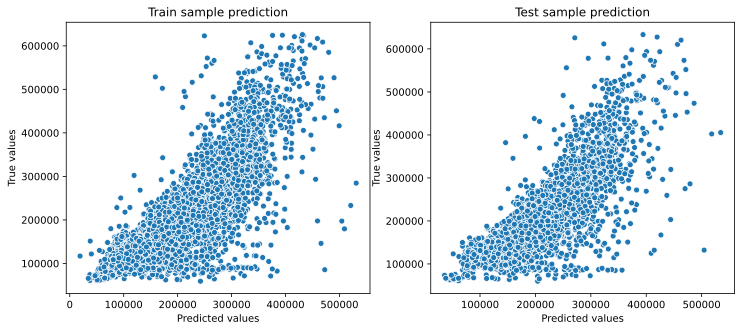

In [4214]:
y_train_preds = lr_model.predict(X_train)
y_test_preds = lr_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Можно сделать вывод, что модель дает невысокий R2, то есть скорее недообучена. Возможные способы решения: лучше обработать выбросы, добавить фичей побольше.

Train R2:	-1.099
Test R2:	-1.016


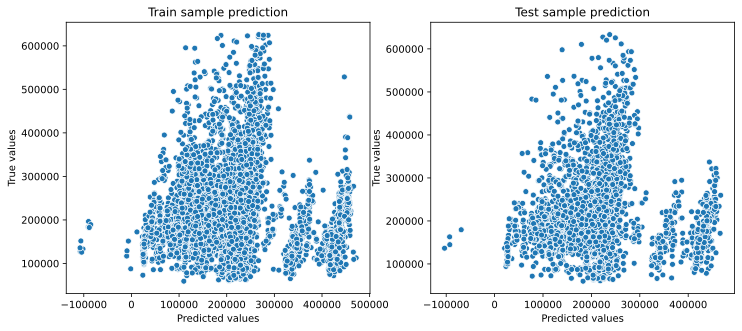

In [4215]:
# после стандартизации все стало хуже.
y_train_preds = lr_model.predict(X_train_scaled)
y_test_preds = lr_model.predict(X_valid_scaled)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

## Random Forest

In [4216]:
%%time
rf_model = RandomForestRegressor()
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10],
         'min_samples_leaf':[20, 30, 40, 50]}

gs = GridSearchCV(rf_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

Wall time: 3min 3s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [20, 30, 40, 50],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [4217]:
gs.best_params_

{'max_depth': 10, 'min_samples_leaf': 20, 'n_estimators': 100}

Train R2:	0.732
Test R2:	0.679


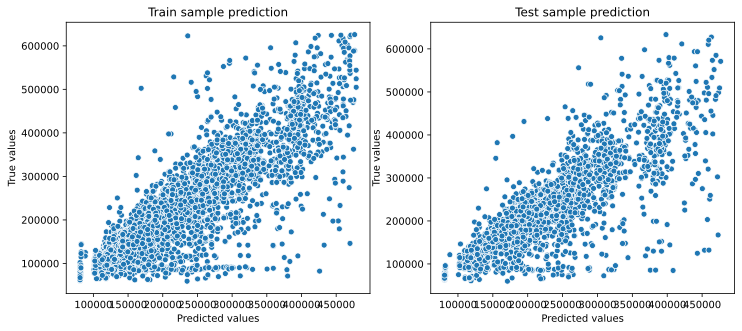

In [4218]:
#снчала подобрала max_depth=10 и n_estimators=400
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=10, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=400  # кол-во деревьев
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Модель переобучена. Высокие цены занижает

Train R2:	0.752
Test R2:	0.69


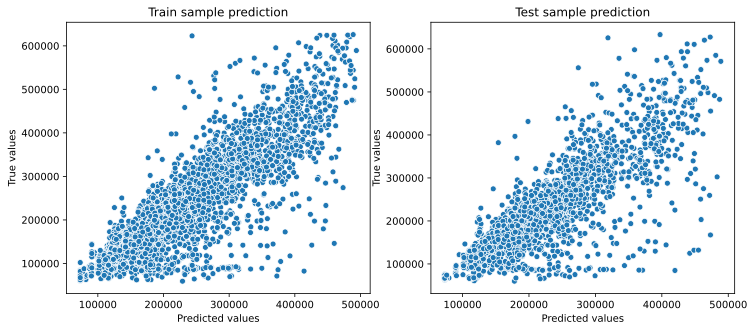

In [4219]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=10, # глубина дерева  
                                 min_samples_leaf=20, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=50  # кол-во деревьев
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Особо ничего не изменилось

**Важность признаков**

In [4220]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

feature_name  importance
1            Square    0.523008
15     DistrictSize    0.287787
11         Social_3    0.041068
0             Rooms    0.037594
7         Ecology_1    0.032029
10         Social_1    0.025278
2        LifeSquare    0.010761
6         HouseYear    0.009161
3     KitchenSquare    0.008338
5        HouseFloor    0.007871
4             Floor    0.006377
13          Shops_1    0.006099
12     Healthcare_2    0.004153
14          Shops_2    0.000291
16  IsDistrictLarge    0.000184
9         Ecology_3    0.000000
8         Ecology_2    0.000000

Делаем вывод, что наибольший вклад вносят  Square и DistrictSize

Лучше подходит модель случайный лес

**Предсказания на тестовом датасете**


In [4221]:
predictions = rf_model.predict(test_df)
predictions


array([158374.7710274 , 242111.83482219, 326807.7121889 , ...,
       306816.9643104 , 201014.60227849, 155801.16827471])

In [4222]:
submit = pd.read_csv('D:\\DS\\datasets\\sample_submission.csv')
submit.head()

Id     Price
0  4567  200000.0
1  5925  200000.0
2   960  200000.0
3  3848  200000.0
4   746  200000.0

In [4223]:
submit['Price'] = predictions
submit.head(10)

Id          Price
0  4567  158374.771027
1  5925  242111.834822
2   960  326807.712189
3  3848  314552.512045
4   746  137115.913525
5   868  180749.254635
6   672  163282.969214
7  2471  219772.233515
8  4510  301117.764253
9  8354  211222.847734

In [4224]:
submit.to_csv('rf_submit.csv', index=False)


**Выводы**  
Для предсказания цен на квартиры была проделана работа:

1. Загрузили данные.
2. Провизуализировали и проанализировали данные.
3. Выполнили предварительную обработку данных.
4. Обработали пропуски и выбросы.
5. Сгенерировали новые признаки.
6. Подготовили исходные данные.
7. Обучили модель.
8. Выполнили проверку качества модели (Лучший результат показала модель Random Forest Regressor).
9. Оценили, какие признаки оказывают наибольшее влияние.